In this example, we will predict stock prices for the next day, based on the time series patterns observed for the previous days.




## 03.01. Setup Environment

Please make sure that the setup environment is executed once successfully, before attempting to use any of the exercise files in this course.

In [1]:
!pip install keras
!pip install tensorflow
!pip install pandas
!pip install matplotlib
!pip install sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [4]:
!git clone https://github.com/LinkedInLearning/recurrent-neural-networks-2478142.git

Cloning into 'recurrent-neural-networks-2478142'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 47 (delta 1), reused 0 (delta 0), pack-reused 41
Receiving objects: 100% (47/47), 66.72 MiB | 54.52 MiB/s, done.
Resolving deltas: 100% (13/13), done.


## 03.02.Load & Split Stock Data

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1)

#Load the Meta stock price data from CSV
prices = pd.read_csv('/content/recurrent-neural-networks-2478142/Exercise Files/FB-stock-prices.csv')

#Review loaded data
print(prices.dtypes)
prices.head()

Date     object
Price     int64
dtype: object


,Date,Price
0,1/4/2021,269
1,1/5/2021,271
2,1/6/2021,263
3,1/7/2021,269
4,1/8/2021,268


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


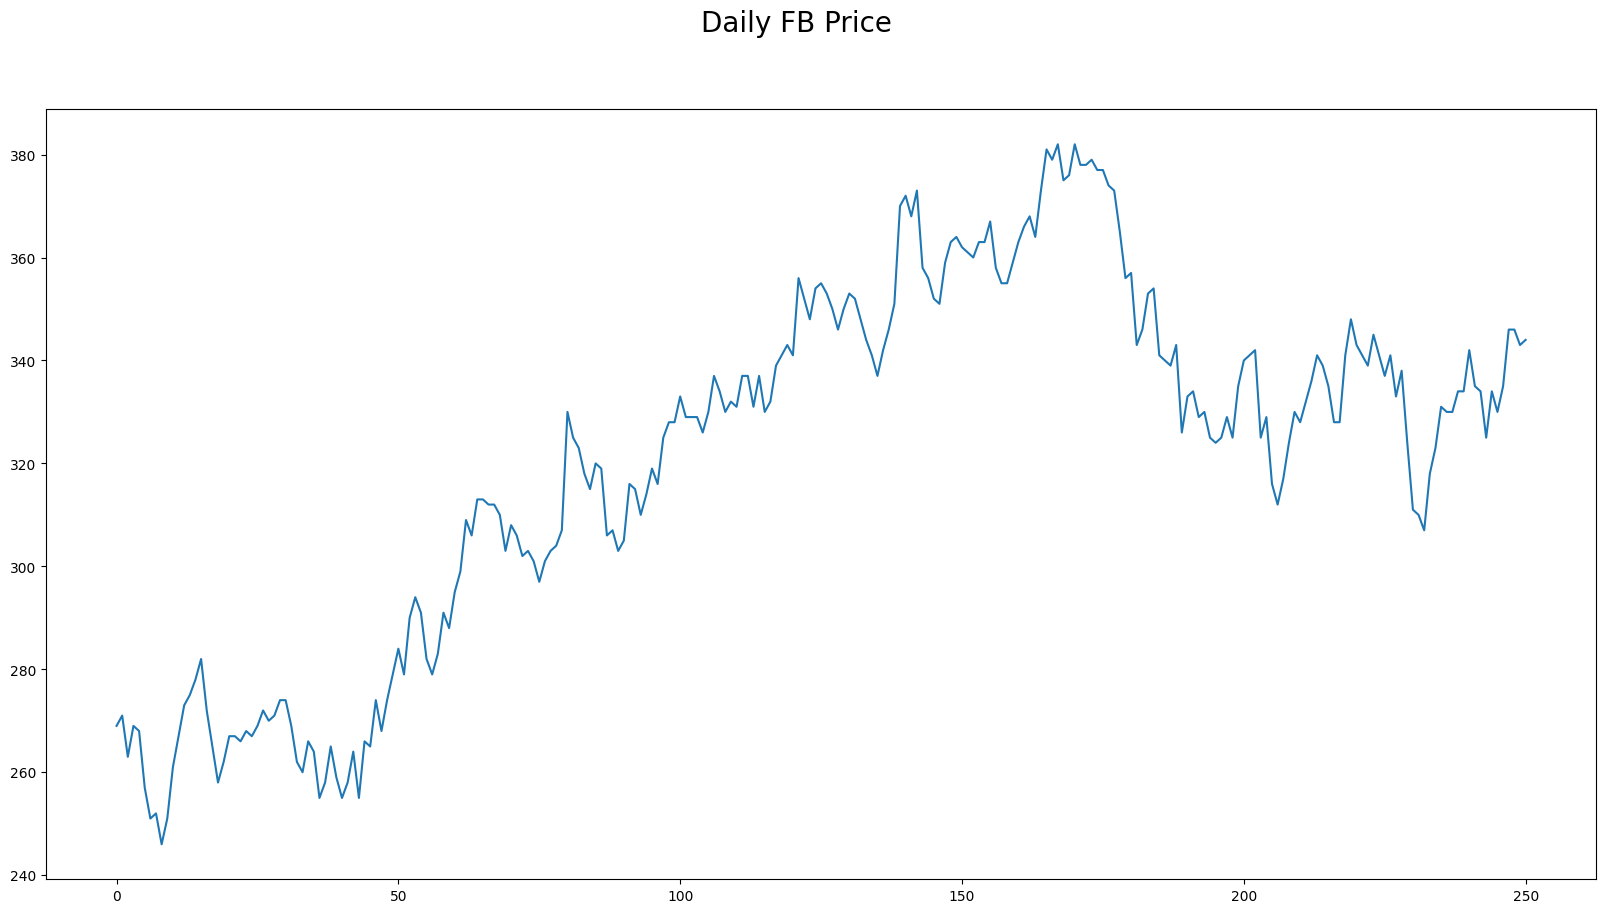

In [7]:
# Plot the data to visualize the stock price

plt.figure(figsize=(20,10)).suptitle("Daily FB Price", fontsize=20)
plt.plot(prices["Price"])
plt.show()

### Split Data

In [8]:
from sklearn.preprocessing import StandardScaler

# Scale the Data
scaler = StandardScaler()
scaled_prices=scaler.fit_transform(prices[["Price"]].values)

#Split data into Training and Test sets
total_size = len(scaled_prices)

#Test dataset size
test_size = 50

#Training dataset size
train_size = total_size - test_size
print(train_size, test_size)

training_prices = scaled_prices[0:train_size,:]
test_prices = scaled_prices[train_size:,:]

print(training_prices.shape, test_prices.shape)

201 50
(201, 1) (50, 1)


## 03.03 Create Dataset for RNN

In [9]:
#Prepare RNN Dataset.
#Each data point (X) is linked to the previous data points of size=lookback
#The predicted value (Y) is the next point

def create_rnn_dataset(data, lookback=1):

    data_x, data_y = [], []
    for i in range(len(data)- lookback -1):
            #All points from this point, looking backwards upto lookback
            a = data[i:(i+ lookback), 0]
            data_x.append(a)
            #The next point
            data_y.append(data[i + lookback, 0])
    return np.array(data_x), np.array(data_y)

#lookback for 25 previous days
lookback=25

#Create X and Y for training
train_req_x, train_req_y = create_rnn_dataset(training_prices,lookback)

#Reshape for use with RNN
train_req_x = np.reshape(train_req_x,
                         (train_req_x.shape[0],1, train_req_x.shape[1]))

print("Shapes of X, Y: ",train_req_x.shape, train_req_y.shape)

Shapes of X, Y:  (175, 1, 25) (175,)


## 03.04 Build the RNN Model

In [11]:
from keras.models import Sequential
from keras.layers import SimpleRNN,Dense
import tensorflow as tf

tf.random.set_seed(3)

#Create a Keras Model
price_model=Sequential()
#Add Simple RNN layer with 32 nodes
price_model.add(SimpleRNN(32, input_shape=(1,lookback)))
#Add a Dense layer at the end for output
price_model.add(Dense(1))

#Compile with Adam Optimizer. Optimize for minimum mean square error
price_model.compile(loss="mean_squared_error",
                 optimizer="adam",
                 metrics=["mse"])

#Print model summary
price_model.summary()

#Train the model
price_model.fit(train_req_x, train_req_y,
             epochs=20, batch_size=1, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 32)                1856      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1889 (7.38 KB)
Trainable params: 1889 (7.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
175/175 [==============================] - 2s 3ms/step - loss: 0.1393 - mse: 0.1393
Epoch 2/20
175/175 [==============================] - 0s 2ms/step - loss: 0.0541 - mse: 0.0541
Epoch 3/20
175/175 [==============================] - 0s 2ms/step - loss: 0.0472 - mse: 0.0472
Epoch 4/20
175/175 [==============================] - 0s 2ms/step - loss: 0.0416 - mse: 0.0416
Epoch 5/20
175/175 [==================

## 03.05. Test the Model

In [12]:
#Preprocess the test dataset, the same way training set is processed
test_req_x, test_req_y = create_rnn_dataset(test_prices,lookback)

print(test_req_x.shape, test_req_y.shape)

test_req_x = np.reshape(test_req_x,
                         (test_req_x.shape[0],1, test_req_x.shape[1]))

#Evaluate the model
price_model.evaluate(test_req_x, test_req_y, verbose=1)

#Predict on the test dataset
predict_on_test = price_model.predict(test_req_x)

#Inverse the scaling to view results
predict_on_test = scaler.inverse_transform(predict_on_test)

(24, 25) (24,)
1/1 [==============================] - 0s 128ms/step


## Visualize the Results

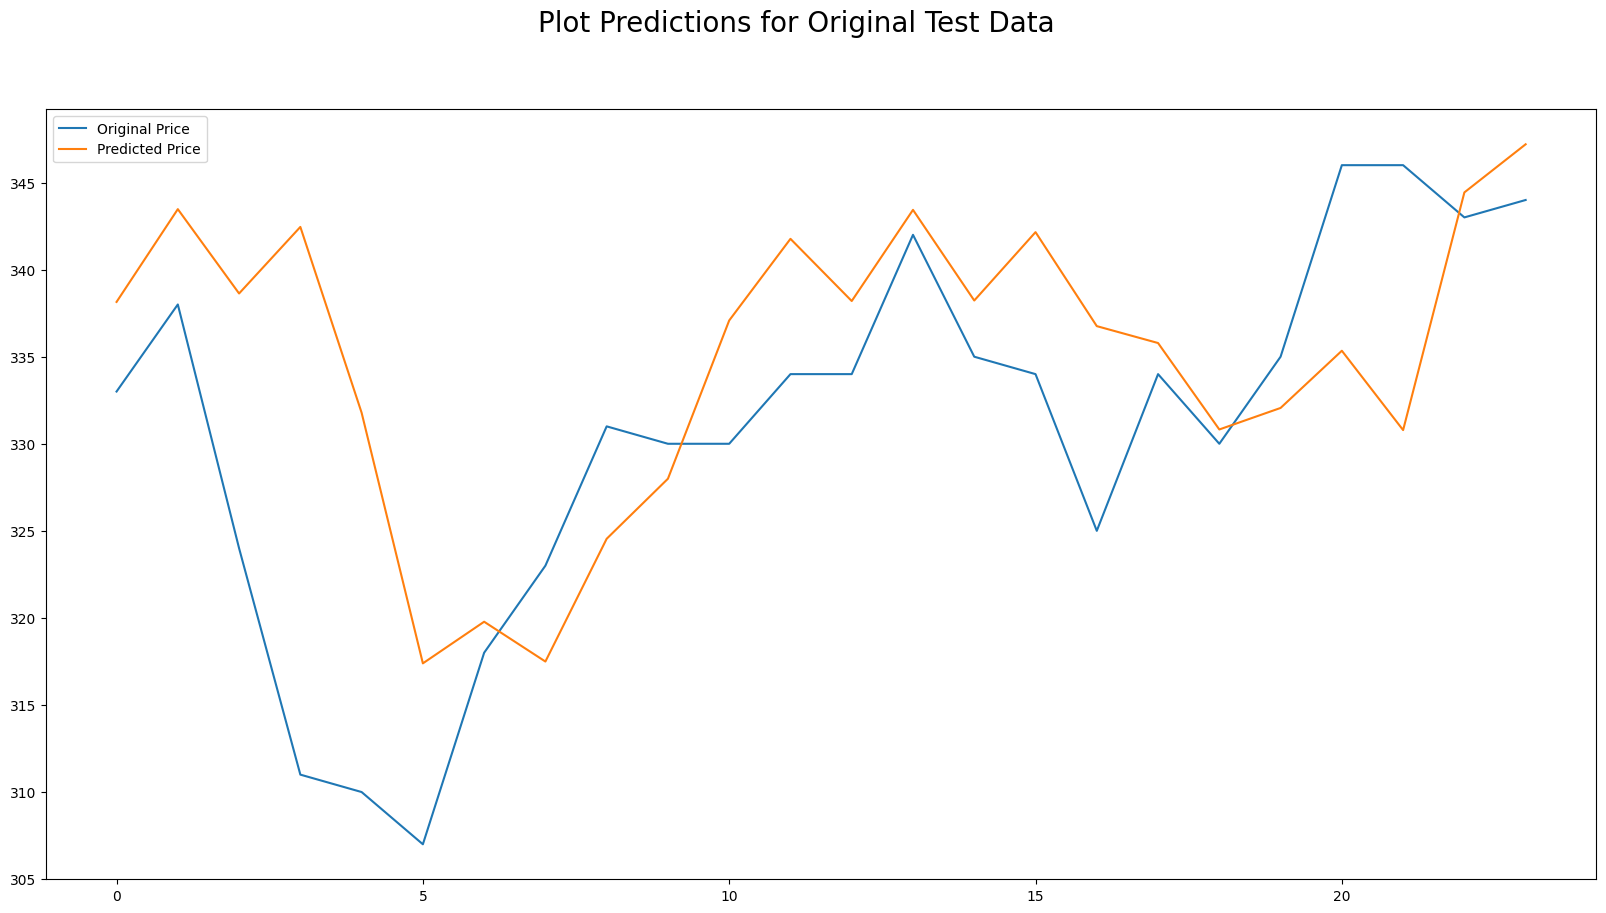

In [13]:
#Extract original test values that map to the same dates on the predicted test values
orig_test_values = prices[["Price"]].loc[total_size-len(predict_on_test):]
orig_test_values.reset_index(drop=True, inplace=True)

plt.figure(figsize=(20,10)).suptitle("Plot Predictions for Original Test Data", fontsize=20)
plt.plot(orig_test_values, label="Original Price")
plt.plot(predict_on_test, label="Predicted Price")
plt.legend()
plt.show()

Accuracy can be increased by having more data points, creating more lookback and trying other RNN models

### Predictions

In [14]:
#Previous prices
previous_prices = np.array([325,335,340,341,342,
                            325,329,316,312,317,
                            324,330,328,332,336,
                            341,339,335,328,328,
                            341,348,343,341,339])

#Scale
scaled_prices = scaler.transform(previous_prices.reshape(-1, 1))
#Reshape
model_input = np.reshape(scaled_prices,
                         (scaled_prices.shape[1],1, scaled_prices.shape[0]))

#predictions
prediction = price_model.predict(model_input)

#scale back
norm_prediction = scaler.inverse_transform(prediction)

print("The predicted Stock price is :", norm_prediction[0][0])

1/1 [==============================] - 0s 15ms/step
The predicted Stock price is : 340.88306
